In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

#statistical tests & linear fits
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols

#visual EDA
import matplotlib.pyplot as plt
import seaborn as sns

#non linears
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#parameter optimization
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#explanability
from sklearn import tree
from dtreeviz.trees import dtreeviz
import lime.lime_tabular
import shap

In [3]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
carPrices = pd.read_csv('/Users/bala/Documents/Learning/carPricePrediction/carPrices.csv')
carPrices.drop('car_ID', axis='columns', inplace=True)
print('All data shape: ', carPrices.shape)

All data shape:  (205, 25)


In [4]:
catCols = carPrices.select_dtypes(include=object).columns
carPrices[catCols] = carPrices[catCols].astype('category')
print('Categorical data shape: ', carPrices[catCols].shape)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numCols = carPrices.select_dtypes(include=numerics).columns
numCols_list = numCols.to_list()
print('Numeric data shape: ', carPrices[numCols_list].shape)

Categorical data shape:  (205, 10)
Numeric data shape:  (205, 15)


## Exploring numeric data

In [5]:
price = carPrices['price']
carPrices.drop('price', axis='columns',inplace = True)
carPrices.insert(0, 'price', price)
print(carPrices[numCols_list].describe())

        symboling   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000   
mean     0.834146   98.756585  174.049268   65.907805   53.724878   
std      1.245307    6.021776   12.337289    2.145204    2.443522   
min     -2.000000   86.600000  141.100000   60.300000   47.800000   
25%      0.000000   94.500000  166.300000   64.100000   52.000000   
50%      1.000000   97.000000  173.200000   65.500000   54.100000   
75%      2.000000  102.400000  183.100000   66.900000   55.500000   
max      3.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844    0.313597          3.972040   
min    1488.000000   61.000000    2.540000    2.070000          7.000000  

In [6]:
#since the numerical features values are in the ten of thousands in some columns (like 'price') 
#but only in the single digits in others (like 'compressionratio'), we scale them to have uniform effect

scaler = preprocessing.StandardScaler()
carPrices[numCols_list] = scaler.fit_transform(carPrices[numCols_list])
carPrices[numCols_list].describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02,2.050000e+02
mean,4.332578e-17,-1.291108e-15,3.656696e-15,1.089643e-15,-5.372396e-16,1.126470e-16,3.466062e-17,2.252940e-15,2.062307e-15,-3.639365e-16,1.819683e-16,2.772850e-16,1.104807e-16,1.473076e-16,1.992986e-16
std,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00,1.002448e+00
min,-2.281433e+00,-2.023713e+00,-2.677244e+00,-2.620512e+00,-2.430664e+00,-2.055348e+00,-1.586561e+00,-2.923049e+00,-3.789311e+00,-7.931011e-01,-1.422573e+00,-2.049347e+00,-1.872388e+00,-2.147310e+00,-1.023762e+00
25%,-6.714717e-01,-7.085959e-01,-6.296552e-01,-8.447824e-01,-7.076263e-01,-7.904486e-01,-7.199469e-01,-6.653141e-01,-4.648342e-01,-3.892993e-01,-8.648707e-01,-6.832865e-01,-9.530117e-01,-8.371954e-01,-6.887281e-01
50%,1.335090e-01,-2.924196e-01,-6.900603e-02,-1.905661e-01,1.538927e-01,-2.725519e-01,-1.662771e-01,-7.312136e-02,1.105560e-01,-2.883489e-01,-2.311186e-01,1.573661e-01,-1.868650e-01,-1.093538e-01,-3.741476e-01
75%,9.384897e-01,6.065210e-01,7.354037e-01,4.636501e-01,7.282388e-01,7.305117e-01,3.392475e-01,9.262039e-01,4.941494e-01,-1.873985e-01,3.012332e-01,7.878555e-01,7.325109e-01,4.729195e-01,4.048375e-01
max,1.743470e+00,3.686225e+00,2.766741e+00,2.987056e+00,2.492302e+00,2.907988e+00,4.792679e+00,2.258638e+00,2.923575e+00,3.244916e+00,4.661448e+00,3.099650e+00,3.643868e+00,3.384286e+00,4.030858e+00


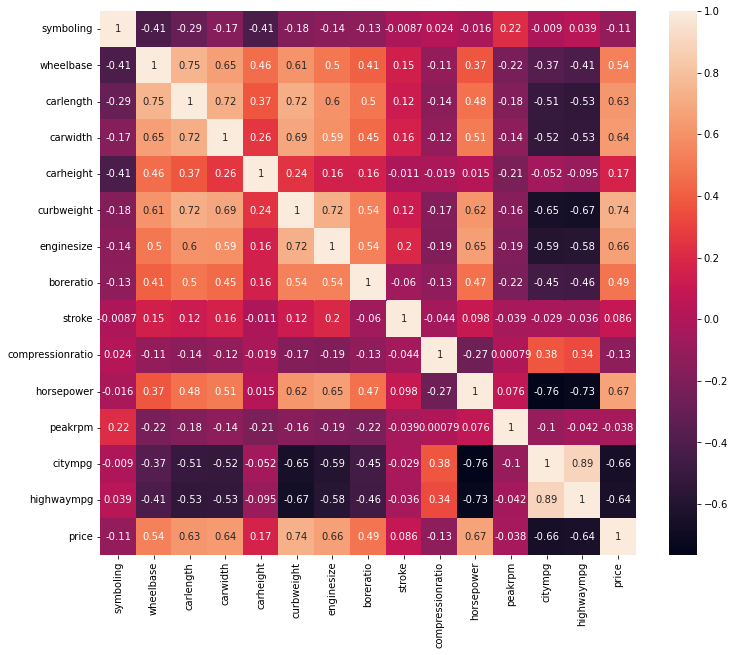

In [7]:
plt.figure(figsize = (12,10))
ax = sns.heatmap(carPrices[numCols_list].corr(method='kendall'), annot=True);

#why Kendall?
#Pearson correlation assumes linear relationship between variables and normal distribution for each variable
#Spearman and Kendall correlation only assume monotonic relationship between variables. Kendall is preferred over Spearman
#for robustness to outliers and small samples + ease of interpretation: 
#https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall

In [8]:
# remove('citympg')#for collinearity with 'highwaympg'
# remove(['peakrpm', 'compressionratio', 'stroke', 'symboling'])#for lack of relation to 'price'
#'curbweight' collinearity with multiple features is to be expected - the larger the dimensions of the car, the heavier it will be
# remove(''carlength', 'carwidth', 'carheight)
print('Numeric data shape, before trimming: ', carPrices[numCols_list].shape)
unwanted = {'citympg', 'enginesize','carlength', 'peakrpm', 'compressionratio', 'stroke', 'symboling', 
    'carlength', 'carwidth', 'carheight',}
numCols_list = [e for e in numCols.to_list() if e not in unwanted]
print('Numeric data shape, after trimming: ', carPrices[numCols_list].shape)


Numeric data shape, before trimming:  (205, 15)
Numeric data shape, after trimming:  (205, 6)


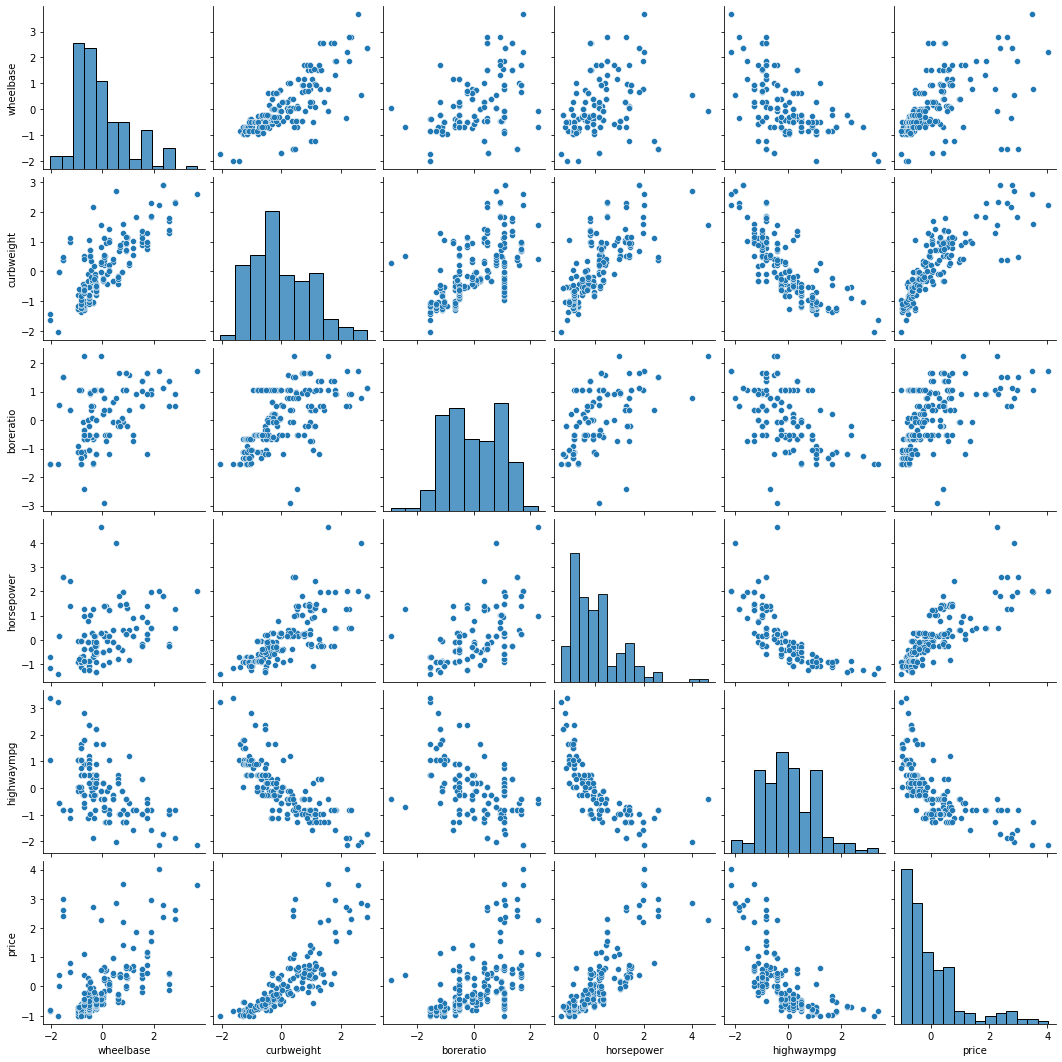

In [9]:
sns.pairplot(carPrices[numCols_list]);

#the diagonal shows why Pearson correlation wasn't a good choice - features are not normally distributed  
#further, there is no clear linear relationship of features to 'price' (the 2 assumptions of Pearson)
#although, there is enough findings in literature, corroborated with this dataset, that Pearson assumptions are unimportant

#'carwidth' may have to be dropped as well for it's strong relationship with 'curbweight'

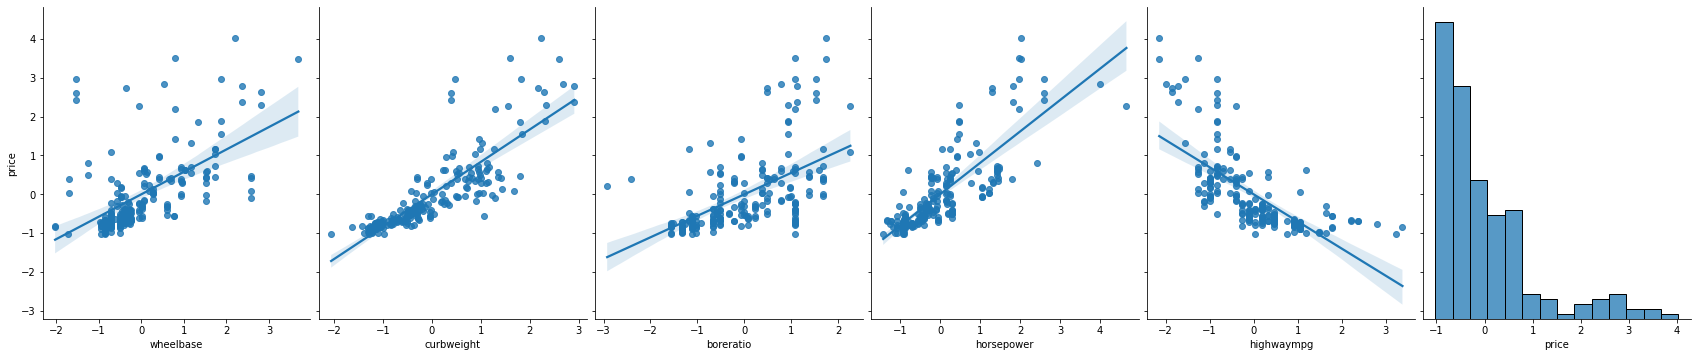

In [10]:
sns.pairplot(carPrices[numCols_list], 
    x_vars=carPrices[numCols_list[0:]], y_vars=['price'], 
    height=5, aspect=.8, kind="reg");

#note the non linear relationship between highwaympg and price
#no clear linear relationships, 'curbweight' seems the best of the lot, visually
#this is confirmed by the fact that 'curbweight' has the highest correlation with the price in the correlation matrix
#the other features that have correlation to price also have high correlation to 'curbweight' - this is to be expected
#for example, a car with a longer 'wheelbase' will be heavier
#similarly, a heavier car will need a bigger 'enginesize' that produces more 'horsepower' and hence have lower 'highwaympg' & 'citympg'

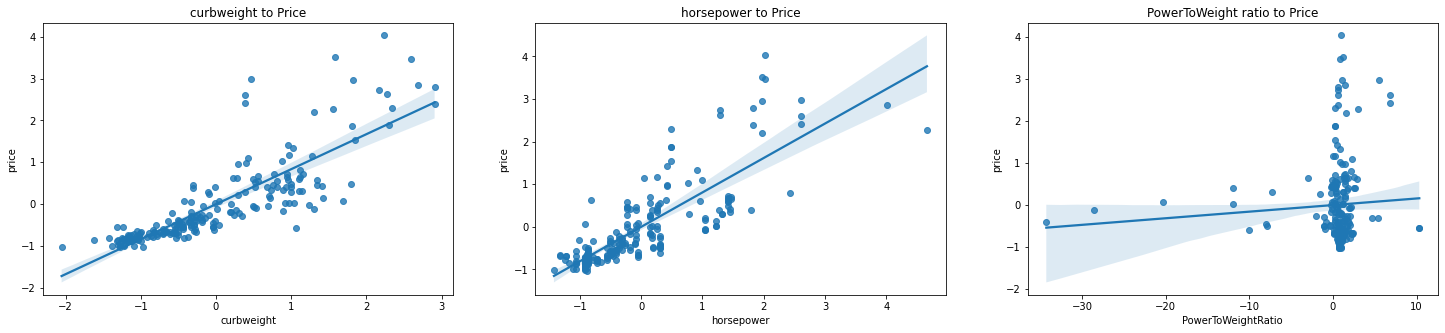

In [11]:
carPrices['PowerToWeightRatio'] = carPrices['horsepower']/carPrices['curbweight']

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (25,5))
sns.regplot(x=carPrices["curbweight"], y=carPrices["price"], ax=ax1).set_title('curbweight to Price')
sns.regplot(x="horsepower", y="price", data=carPrices, ax=ax2).set_title('horsepower to Price')
sns.regplot(x=carPrices['PowerToWeightRatio'], y=carPrices["price"], ax=ax3).set_title('PowerToWeight ratio to Price');

#'curbweight' seemed the best predictor of price, but the relationship isn't linear
#'horsepower' has high collinearity with 'curbweight', as seen in the correlation matrix
#engineered feature (Power:Weight ratio) can also be explored, but in this case, there is no clear relationship to 'price'

# Statistical tests to see if a linear model is appropriate  
   
#since 'price' to 'curbweight' doesn't seem a linear relationship, we explore transformed features  
#it is not enough to visualize fit and hence we fit linear models to check statistical properties

## Assumptions of linear model  
#Linear fit  
#Errors are random - confirmed by normal distribution of residuals  
#Constant variance of errors - tested by residuals v/s fitted values  
#Independent features - confirmed by the absence of multi-collinearity 
  
## Desired test results  
#Explained variance, rsquared_adj, close to 1  
#Homoskedasticity Durbin Watson test, close to 2  
#Normal distribution of residuals Omnibus test & p-value, null hypothesis is normal distribution, hence high p-value  
#Normal distribution of residuals Jarque Bera test & p-value, null hypothesis is normal distribution, hence high p-value  
#Multi collinearity Condition Number test, sensitivity of output to input, below 30  

## Reference:  
https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/linear_model.py#L2335  
https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate  
https://www.investopedia.com/terms/d/durbin-watson-statistic.asp  

In [12]:
def linearModelCheck(my_formula, carPrices):
    print('_'*50)
    print(my_formula)
    model_1 = ols(formula=my_formula, data=carPrices).fit()
    print('Explained variance, rsquared_adj: ', round(model_1.rsquared_adj,2))
    residuals = model_1.resid
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    print('Homoskedasticity Durbin Watson test: ', round(durbinwatson,2))
    omni, omnipv = sm.stats.stattools.omni_normtest(residuals, axis=0)
    print('Normal distribution of residuals Omnibus test & p-value : ', round(omni,2), ' , ', round(omnipv,2))
    jb, jbpv, skew, kurtosis = sm.stats.stattools.jarque_bera(residuals, axis=0)
    print('Normal distribution of residuals Jarque Bera test & p-value : ', round(jb,2), ' , ', round(jbpv,2))
    print('Multi collinearity Condition Number test: ', round(model_1.condition_number,2))
    print('+'*50)

In [13]:
#Inference - None of the scaled or further transformations for the 'price' feature can be fit into a linear model
#the Adjusted R-Squared/ explained variance is best for the scaled but other wise untransformed 'price' feature   
#the homoskedasticity/ autocorrelation Durbin Watson test results imply an undesirable relationship between variables whereas
#we desire random residuals/ errors with constant variance
#the null hypothesis of normal distribution for residuals is rejected in both Omnibus and Jarque Bera tests 
carPrices['price_sqr'] = carPrices['price']**2
carPrices['price_log'] = np.log(carPrices['price'])
carPrices['price_exp'] = np.exp(carPrices['price'])
carPrices['price_sin'] = np.sin(carPrices['price'])
print(carPrices[['price_sqr', 'price_log', 'price_exp', 'price_sin']].head())
for col in ['price','price_sqr', 'price_log', 'price_exp', 'price_sin']:
    print('_'*50)
    my_formula = col+"~curbweight"
    linearModelCheck(my_formula, carPrices)

   price_sqr  price_log  price_exp  price_sin
0   0.000750  -3.597536   1.027770   0.027388
1   0.163589  -0.905200   1.498495   0.393523
2   0.163589  -0.905200   1.498495   0.393523
3   0.007138  -2.471182   1.088156   0.084384
4   0.274228  -0.646898   1.688208   0.500060
__________________________________________________
__________________________________________________
price~curbweight
Explained variance, rsquared_adj:  0.7
Homoskedasticity Durbin Watson test:  0.57
Normal distribution of residuals Omnibus test & p-value :  85.36  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  382.85  ,  0.0
Multi collinearity Condition Number test:  1.0
++++++++++++++++++++++++++++++++++++++++++++++++++
__________________________________________________
__________________________________________________
price_sqr~curbweight
Explained variance, rsquared_adj:  0.23
Homoskedasticity Durbin Watson test:  0.67
Normal distribution of residuals Omnibus test & p-value :  157.59  ,

In [14]:
#Inference - None of the scaled or further transformations for the 'curbweight' feature can be fit into a linear model
#the Adjusted R-Squared/ explained variance is best for the scaled but other wise untransformed 'curbweight' feature   
#the homoskesticity/ autocorrelation Durbin Watson test results imply an undesirable relationship between variables whereas
#we desire random residuals/ errors with constant variance
#the null hypothesis of normal distribution for residuals is rejected in both Omnibus and Jarque Bera tests 
carPrices['curbweight_log'] = np.log(carPrices['curbweight']+1)
carPrices['curbweight_exp'] = np.exp(carPrices['curbweight'])
carPrices['curbweight_sin'] = np.sin(carPrices['curbweight'])
print(carPrices[['curbweight_log', 'curbweight_exp', 'curbweight_sin']].head())
for col in ['curbweight', 'curbweight_log', 'curbweight_exp', 'curbweight_sin']:
    print('_'*50)
    my_formula = "price~"+col
    linearModelCheck(my_formula, carPrices)

   curbweight_log  curbweight_exp  curbweight_sin
0       -0.014673        0.985539       -0.014566
1       -0.014673        0.985539       -0.014566
2        0.415337        1.673441        0.492432
3       -0.546103        0.656523       -0.408488
4        0.416608        1.676666        0.494107
__________________________________________________
__________________________________________________
price~curbweight
Explained variance, rsquared_adj:  0.7
Homoskedasticity Durbin Watson test:  0.57
Normal distribution of residuals Omnibus test & p-value :  85.36  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  382.85  ,  0.0
Multi collinearity Condition Number test:  1.0
++++++++++++++++++++++++++++++++++++++++++++++++++
__________________________________________________
__________________________________________________
price~curbweight_log
Explained variance, rsquared_adj:  0.38
Homoskedasticity Durbin Watson test:  0.81
Normal distribution of residuals Omnibus tes

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     468.6
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           1.21e-54
Time:                        09:17:37   Log-Likelihood:                -168.25
No. Observations:                 205   AIC:                             340.5
Df Residuals:                     203   BIC:                             347.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.665e-16      0.039   4.32e-15      1.0

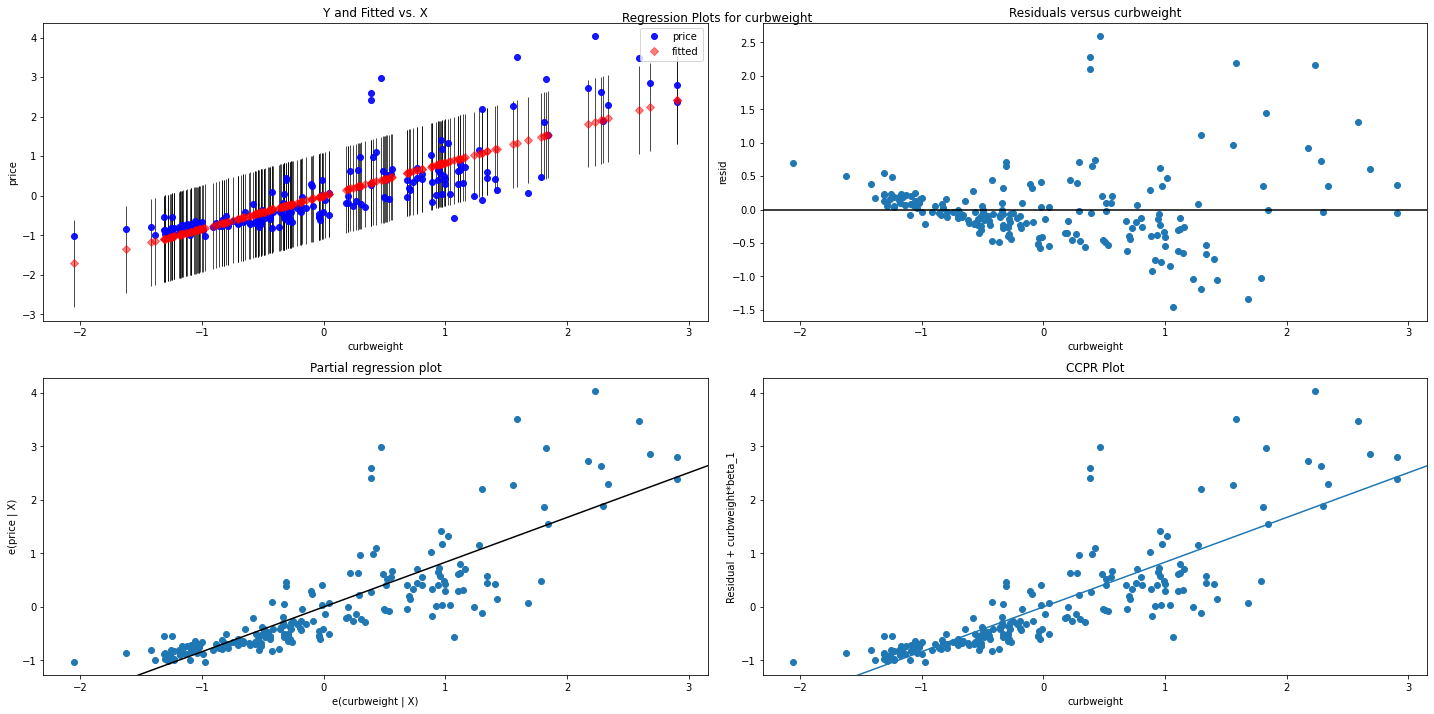

In [15]:
#for curiosity, we explore the best fit above
#there's a clear funnel shape to the residuals v/s 'curbweight' plot, which is undesirable
np.random.seed(5)
model_1 = ols(formula = 'price ~ curbweight', data = carPrices).fit()
plt.rcParams["figure.figsize"] = (20,10)
fig = sm.graphics.plot_regress_exog(model_1, "curbweight")
fig.tight_layout(pad=1.0)

print(model_1.summary())

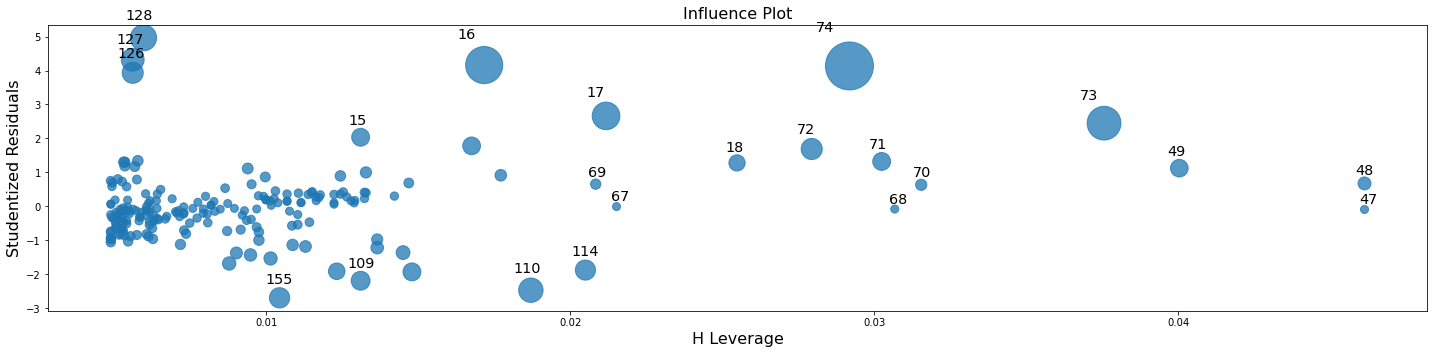

In [16]:
#exploring outliers for influence 
plt.rcParams["figure.figsize"] = (20,5)
fig = sm.graphics.influence_plot(model_1, criterion="cooks")
fig.tight_layout(pad=1.0)

#evaluating the need for outlier treament for point with high influence
#some points may have high influence and need further evaluation (like 74 & 73) 
#some points with high residual (like 128) have low leverage and hence low influence
#some points with high leverage (like 48) have low residual and hence low influence

    curbweight    price
70        3770  31600.0
71        3740  34184.0
72        3685  35056.0
73        3900  40960.0
74        3715  45400.0
75        2910  16503.0


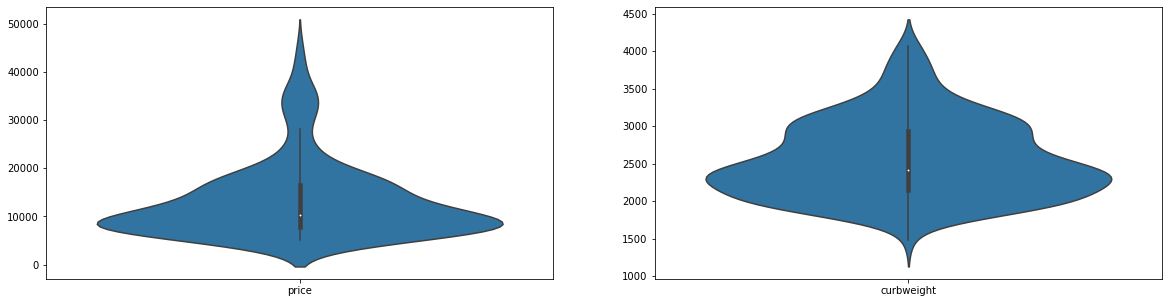

In [17]:
#trimming out the high priced cars (> 30,000) to evaluate impact
carPrices1 = pd.read_csv('/Users/bala/Documents/Learning/carPricePrediction/carPrices.csv')
carPrices1.drop('car_ID', axis='columns', inplace=True)
print(carPrices1.iloc[70:76,[12,24]])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,5))
sns.violinplot(data=carPrices1.loc[:,['price']], ax=ax1)
sns.violinplot(data=carPrices1.loc[:,['curbweight']], ax=ax2)
carPrices1 = carPrices1[carPrices1['price']<30000]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     506.3
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           3.13e-55
Time:                        09:17:38   Log-Likelihood:                -1762.0
No. Observations:                 190   AIC:                             3528.
Df Residuals:                     188   BIC:                             3535.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.209e+04   1065.469    -11.346      0.0

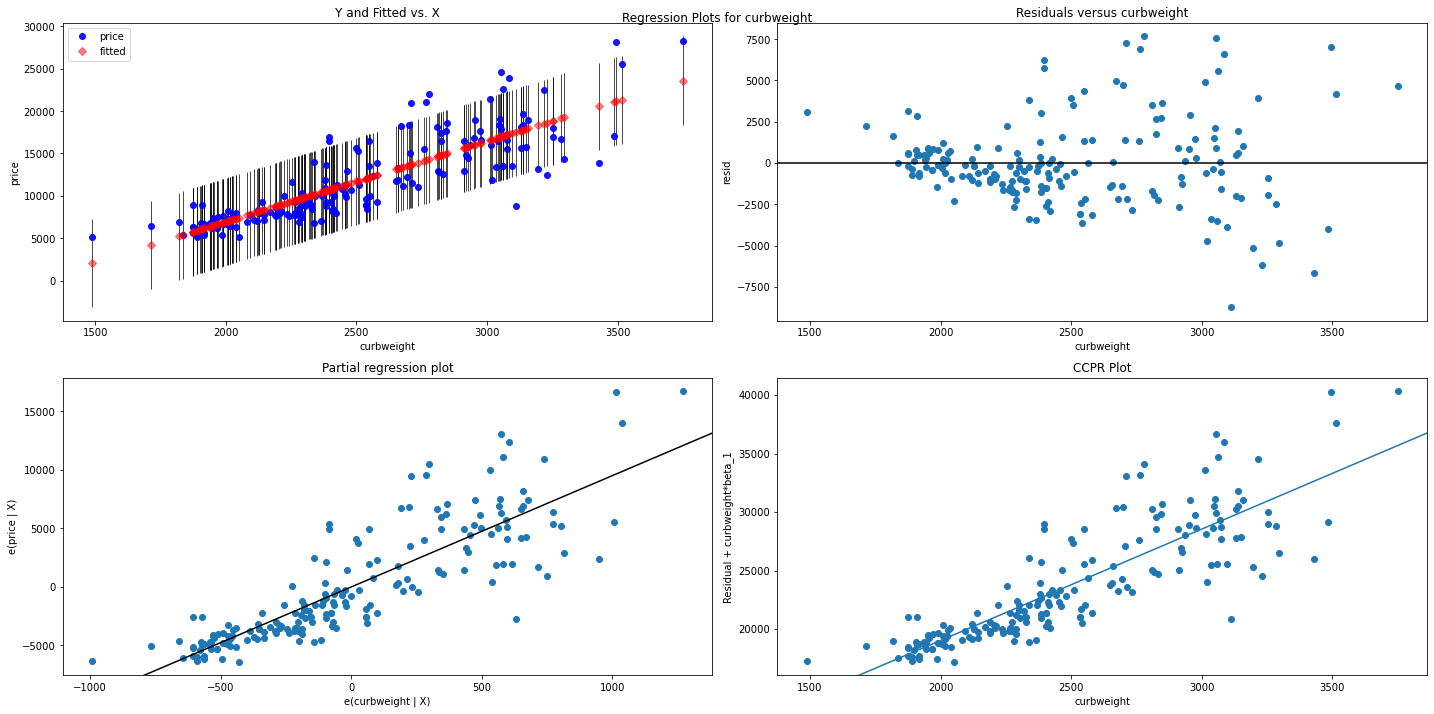

In [18]:
#model fit without the high 'price' points isn't better
np.random.seed(5)
model_2 = ols(formula = 'price ~ curbweight', data = carPrices1).fit()
plt.rcParams["figure.figsize"] = (20,10)
fig = sm.graphics.plot_regress_exog(model_2, "curbweight")
fig.tight_layout(pad=1.0)
print(model_2.summary())

## Exploring categorical variables

In [19]:
(pd.DataFrame(
    carPrices[catCols]
    .melt(var_name='Feature', value_name='Value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['Feature', 'counts'], ascending=False))

counts
Feature        Value              
fueltype       gas             185
               diesel           20
fuelsystem     mpfi            105
               bbl              80
               idi              20
enginetype     ohc             176
               dohc             13
               l                12
               rotor             4
enginelocation front           202
               rear              3
drivewheel     fwd             120
               rwd              76
               4wd               9
doornumber     four            115
               two              90
cylindernumber four            164
               six              35
               eight             6
carbody        sedan            96
               hatchback        70
               wagon            25
               hardtop           8
               convertible       6
aspiration     std             168
               turbo            37
CarName        toyota           32
               nissan           18
               mazda            17
               honda            13
               mitsubishi       13
               subaru           12
               volkswagen       12
               volvo            11
               peugeot          11
               dodge             9
               bmw               8
               buick             8
               audi              7
               plymouth          7
               saab              6
               porsche           5
               isuzu             4
               chevrolet         3
               alfa-romero       3
               jaguar            3
               renault           2
               mercury           1

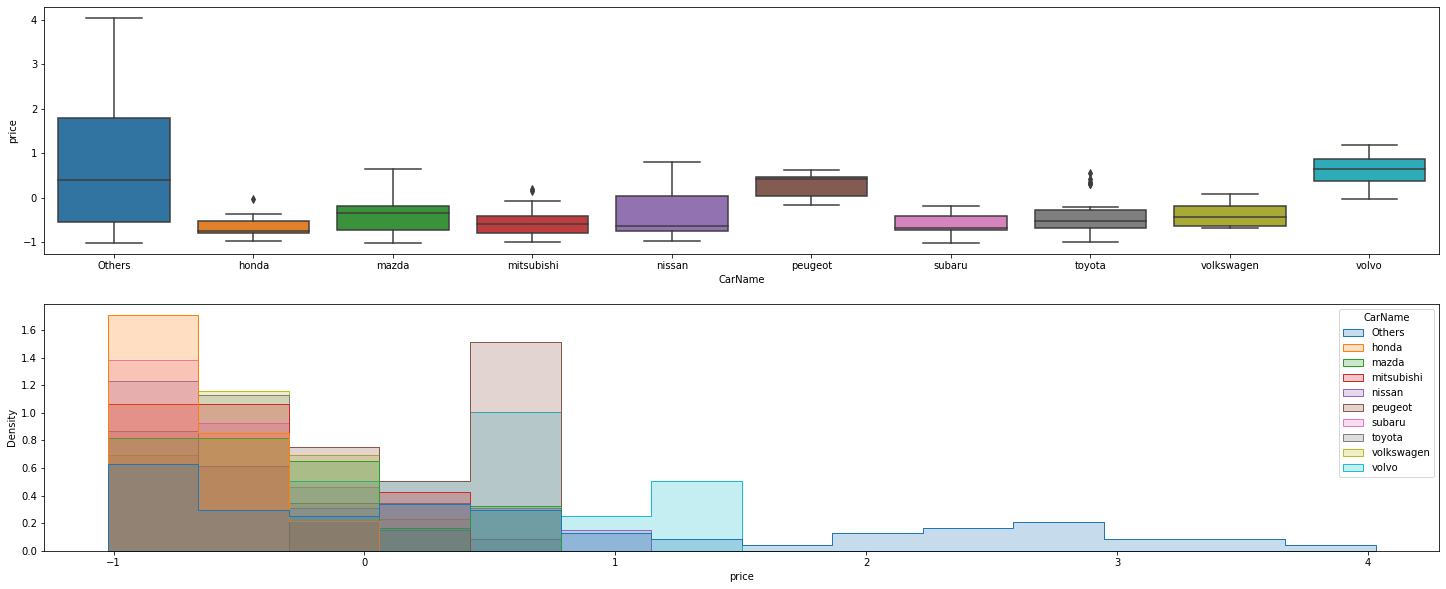

In [20]:
#there are 22 different car makers in the dataset, with one having just one observation
#on the one hand, it is hard to learn to model price, by maker, with insufficient data
#but excluding these would mean we can't predict prices for cars built by that maker
#please note that important price predictors, like curbweight, apply regardless of car maker
#in such a situation, it is better to club such infrequent data into a single bucket like 'other' 
#the price of doing so is that we're conflating the dis-similar prices of expensive Alfa-Romeos and less expensive Chevys
#this is a tradeoff to be made

thresh = 10 #thresold for minimum occurrences
indices_Others = carPrices.groupby('CarName').filter(lambda x : len(x)<thresh)['CarName'].index
carPrices['CarName'] = carPrices['CarName'].astype(str)
carPrices['CarName'][indices_Others] = 'Others'
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize = (25,10))
sns.boxplot(x="CarName", y="price", data=carPrices, ax=ax1)
sns.histplot(data=carPrices, x="price", hue="CarName", element='step', stat="density", common_norm=False, ax=ax2);

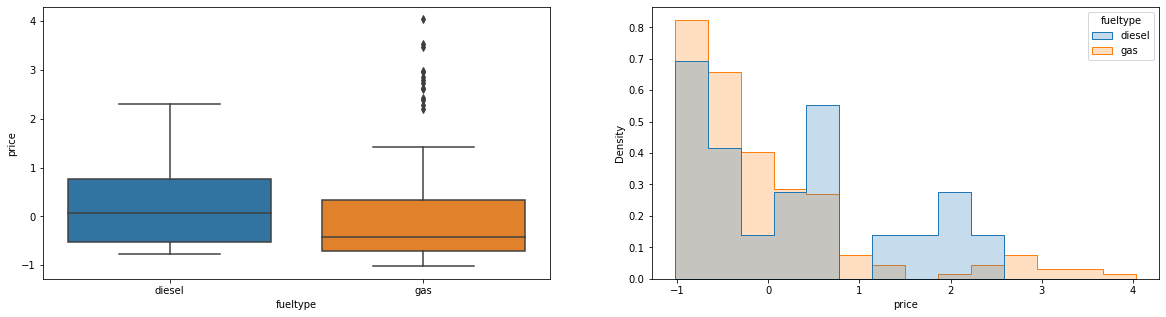

In [21]:
#bivariate analysis with a 2 level variable, 'fueltype'
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,5))
sns.boxplot(x="fueltype", y="price", data=carPrices, ax=ax1)
sns.histplot(data=carPrices, x="price", hue="fueltype", element='step', stat="density", common_norm=False, ax=ax2);

In [22]:
scipy.stats.ranksums(carPrices['price'][carPrices['fueltype']=='diesel'], carPrices['price'][carPrices['fueltype']=='gas'])

#Wilcoxon rank-sum is the non-parametric version of the unpaired two-samples t-test
#For paired samples (like a before/ after) use the Wilcoxon signed-rank test. Again, for non-parametric.
#Non-parametric is considered only because the paired & un-paired two sample t-tests make certain assumption.
#Refer: https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test
#Assumptions:
#1
# # The means of the two populations being compared should follow normal distributions. 
# # Under weak assumptions, this follows in large samples from the central limit theorem, 
# # even when the distribution of observations in each group is non-normal.
#2
# # The two populations being compared should have the same variance 
# # If the sample sizes in the two groups being compared are equal, Student's original t-test is highly robust to 
# # the presence of unequal variances.
#3
# # The alternative Welch's t-test is insensitive to equality of the variances regardless of whether the sample sizes are similar.

#there is a statistically significant difference in price by fueltype and this is enough to include the feature in modelling

RanksumsResult(statistic=1.9958327090644405, pvalue=0.04595213518525119)

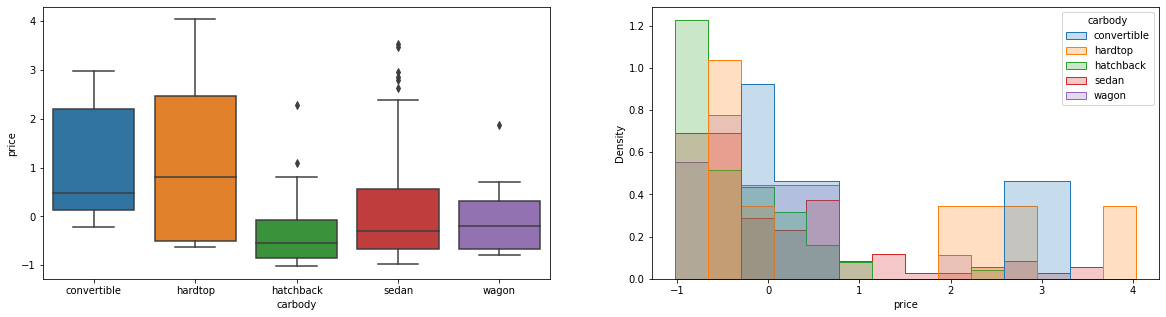

In [23]:
#bivariate analysis with a multi level variable, 'carbody'
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,5))
sns.boxplot(x="carbody", y="price", data=carPrices, ax=ax1)
sns.histplot(data=carPrices, x="price", hue="carbody", element='step', stat="density", common_norm=False, ax=ax2);

In [24]:
scipy.stats.kruskal(carPrices['price'][carPrices['carbody']=='convertible'], 
    carPrices['price'][carPrices['carbody']=='hardtop'],
    carPrices['price'][carPrices['carbody']=='hatchback'],
    carPrices['price'][carPrices['carbody']=='sedan'],
    carPrices['price'][carPrices['carbody']=='wagon'])

#Kruskal Wallis is the non-parametric version of the one-way ANOVA test (3 or more groups)
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway
#The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.
# # The samples are independent.
# # Each sample is from a normally distributed population.
# # The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

#there is a statistically significant difference in price by carbody and this is enough to include the feature in modelling

KruskalResult(statistic=22.183437941390444, pvalue=0.0001842534808688567)

Wilcoxon rank-sum test - null hypothesis - drawn from the same distribution  RanksumsResult(statistic=-2.7844475449085078, pvalue=0.005361899311853995)


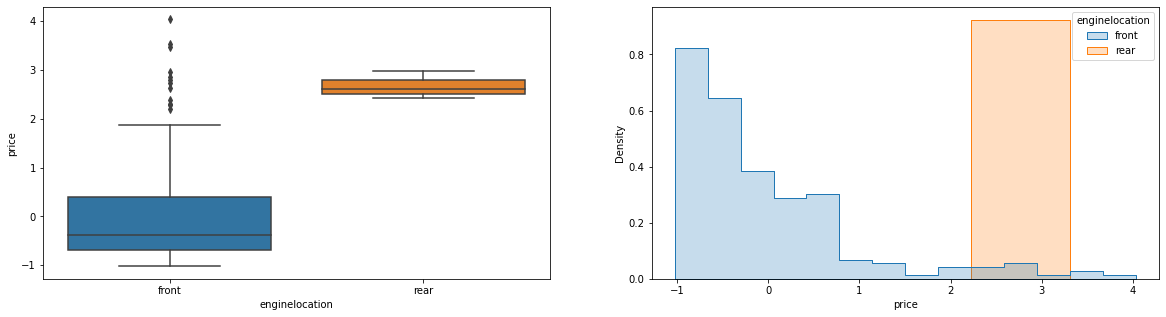

In [25]:
print('Wilcoxon rank-sum test - null hypothesis - drawn from the same distribution ', 
    scipy.stats.ranksums(carPrices['price'][carPrices['enginelocation']=='front'], 
            carPrices['price'][carPrices['enginelocation']=='rear']))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,5))
sns.boxplot(x="enginelocation", y="price", data=carPrices, ax=ax1)
sns.histplot(data=carPrices, x="price", hue="enginelocation", element='step', stat="density", common_norm=False, ax=ax2);

#the plot shows a clear difference in prices by enginelocation (rear engine sports cars?)
#there are very few rear engined cars in the dataset and it is tempting to drop this column (or merge rows when there are more levels)
#but this feature is clearly a strong predictor, when it exists and hence, it must be included

#there is a statistically significant difference in price by enginelocation and this is enough to include the feature in modelling

## Additional considerations for feature selection/ engineering

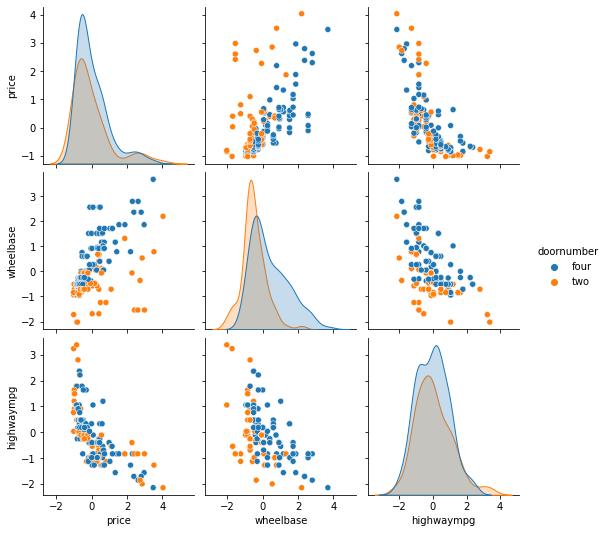

In [26]:
#skipping repetitive tests and dropping the categorical feature that did not show any predictive value. 
catCols_list = catCols.to_list()
catCols_list.remove('doornumber')

#one has to be careful dropping features since a feature that is not useful in a bivariate analysis might be useful 
#in a multivariate model and plot like this can help identify such situations 
# doornumber is still not useful wrt price prediction, but we see some useful information about two door cars having shorter 'wheelbase'

sns.pairplot(carPrices.loc[:,['price','wheelbase','highwaympg','doornumber']], hue='doornumber');

## Modelling

In [27]:
#carPricesCatFeatures = pd.get_dummies(carPrices[catCols_list]) 
carPricesCatFeatures = pd.get_dummies(carPrices[catCols_list], drop_first=True)#ATTENTION: w/o drop first, we end up 
#with collinearity problems during OLS modelling Ref:http://facweb.cs.depaul.edu/sjost/csc423/documents/dummy-variable-trap.htm
print(carPricesCatFeatures.shape)
carPricesNumFeatures = carPrices[numCols_list]
print(carPricesNumFeatures.shape)
carPricesDF = pd.concat([carPricesNumFeatures, carPricesCatFeatures], axis='columns')

(205, 25)
(205, 6)


In [28]:
#some numeric and categorical columns have been dropped above
#model with all the remaining continuous and categorical columns shows good R-Squared & low multi collinearity
#but has poor residuals correlation and distribution

all_columns = carPricesDF.columns.to_list()
all_columns.remove('price')
all_columns = "+".join(all_columns)
np.random.seed(5)
my_formula = "price~" + all_columns
linearModelCheck(my_formula, carPricesDF)

__________________________________________________
price~wheelbase+curbweight+boreratio+horsepower+highwaympg+CarName_honda+CarName_mazda+CarName_mitsubishi+CarName_nissan+CarName_peugeot+CarName_subaru+CarName_toyota+CarName_volkswagen+CarName_volvo+fueltype_gas+aspiration_turbo+carbody_hardtop+carbody_hatchback+carbody_sedan+carbody_wagon+drivewheel_fwd+drivewheel_rwd+enginelocation_rear+enginetype_l+enginetype_ohc+enginetype_rotor+cylindernumber_four+cylindernumber_six+fuelsystem_idi+fuelsystem_mpfi
Explained variance, rsquared_adj:  0.91
Homoskedasticity Durbin Watson test:  1.35
Normal distribution of residuals Omnibus test & p-value :  91.42  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  696.4  ,  0.0
Multi collinearity Condition Number test:  1.349430664867314e+16
++++++++++++++++++++++++++++++++++++++++++++++++++


In [29]:
#picking only 'curbweight' from the continuous features & all the remaining categorical features
#poor residuals correlation and distribution 
all_columns = carPricesDF.columns.to_list()
all_columns.remove('price')
all_columns = [x for x in all_columns if x not in numCols_list]
all_columns.append('curbweight')
all_columns = "+".join(all_columns)
np.random.seed(5)
my_formula = "price~" + all_columns
linearModelCheck(my_formula, carPricesDF)

__________________________________________________
price~CarName_honda+CarName_mazda+CarName_mitsubishi+CarName_nissan+CarName_peugeot+CarName_subaru+CarName_toyota+CarName_volkswagen+CarName_volvo+fueltype_gas+aspiration_turbo+carbody_hardtop+carbody_hatchback+carbody_sedan+carbody_wagon+drivewheel_fwd+drivewheel_rwd+enginelocation_rear+enginetype_l+enginetype_ohc+enginetype_rotor+cylindernumber_four+cylindernumber_six+fuelsystem_idi+fuelsystem_mpfi+curbweight
Explained variance, rsquared_adj:  0.89
Homoskedasticity Durbin Watson test:  1.28
Normal distribution of residuals Omnibus test & p-value :  81.5  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  564.37  ,  0.0
Multi collinearity Condition Number test:  1.9398269600854076e+16
++++++++++++++++++++++++++++++++++++++++++++++++++


In [30]:
#exploring impact of each categorical column at a time, plus 'curbweight'
for col in catCols_list:
    all_columns = carPricesDF.columns.to_list()
    all_columns = [x for x in all_columns if x not in numCols_list]#ditch all numeric cols
    all_columns.append('curbweight')#add back only 'curbweight'
    all_columns = [x for x in all_columns if col in x]#choose one categorical col at a time
    all_columns = "+".join(all_columns)
    my_formula = "price~" + all_columns
    linearModelCheck(my_formula, carPricesDF)

__________________________________________________
price~CarName_honda+CarName_mazda+CarName_mitsubishi+CarName_nissan+CarName_peugeot+CarName_subaru+CarName_toyota+CarName_volkswagen+CarName_volvo
Explained variance, rsquared_adj:  0.25
Homoskedasticity Durbin Watson test:  0.57
Normal distribution of residuals Omnibus test & p-value :  41.4  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  78.05  ,  0.0
Multi collinearity Condition Number test:  6.93
++++++++++++++++++++++++++++++++++++++++++++++++++
__________________________________________________
price~fueltype_gas
Explained variance, rsquared_adj:  0.01
Homoskedasticity Durbin Watson test:  0.46
Normal distribution of residuals Omnibus test & p-value :  80.32  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  197.82  ,  0.0
Multi collinearity Condition Number test:  6.25
++++++++++++++++++++++++++++++++++++++++++++++++++
__________________________________________________
price~aspiration_

In [31]:
#choosing categorical columns that seemed to more informative doesn't help either
all_columns = []
all_columns.append('curbweight')#add back only 'curbweight'
all_columns1 = [x for x in carPricesDF.columns.to_list() if x.startswith('carbody')]#choose one categorical col at a time
all_columns.extend(all_columns1)
all_columns2 = [x for x in carPricesDF.columns.to_list() if x.startswith('enginelocation')]#choose one categorical col at a time
all_columns.extend(all_columns2)
all_columns3 = [x for x in carPricesDF.columns.to_list() if x.startswith('cylindernumber')]#choose one categorical col at a time
all_columns.extend(all_columns3)
all_columns = "+".join(all_columns)
my_formula = "price~" + all_columns
linearModelCheck(my_formula, carPricesDF)

__________________________________________________
price~curbweight+carbody_hardtop+carbody_hatchback+carbody_sedan+carbody_wagon+enginelocation_rear+cylindernumber_four+cylindernumber_six
Explained variance, rsquared_adj:  0.87
Homoskedasticity Durbin Watson test:  0.97
Normal distribution of residuals Omnibus test & p-value :  76.22  ,  0.0
Normal distribution of residuals Jarque Bera test & p-value :  439.3  ,  0.0
Multi collinearity Condition Number test:  20.4
++++++++++++++++++++++++++++++++++++++++++++++++++


# Non-linear models  
It is clear now that a linear model is an inappropriate fit. Hence, we try with a few different non-linear models.  
These are all tree based models but others, like SVM, can also work with non linear data

In [7]:
#reload data and perform only select transformations. e.g. data scaling is not needed for trees
carPrices = pd.read_csv('/Users/bala/Documents/Learning/carPricePrediction/carPrices.csv')
carPrices.drop('car_ID', axis='columns', inplace=True)
print('All data shape: ', carPrices.shape)

#categorical features
catCols = carPrices.select_dtypes(include=object).columns
catCols_list = catCols.to_list()
carPrices[catCols] = carPrices[catCols].astype('category')
print('Categorical data shape: ', carPrices[catCols].shape)
##grouping the very large number of levels for 'CarName'
thresh = 10 #thresold for minimum occurrences
indices_Others = carPrices.groupby('CarName').filter(lambda x : len(x)<thresh)['CarName'].index
carPrices['CarName'] = carPrices['CarName'].astype(str)
carPrices['CarName'][indices_Others] = 'Others'
##dummies
carPricesCatFeatures = pd.get_dummies(carPrices[catCols_list]) 
print('Categorical data shape, after getting dummies: ',carPricesCatFeatures.shape)


#numerical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numCols = carPrices.select_dtypes(include=numerics).columns
numCols_list = numCols.to_list()
carPricesNumFeatures = carPrices[numCols_list]
print('Numeric data shape: ', carPricesNumFeatures.shape)


carPricesDF = pd.concat([carPricesNumFeatures, carPricesCatFeatures], axis='columns')


print('Final data shape', carPricesDF.shape)
y = carPricesDF['price']
X = carPricesDF.drop('price', axis='columns')

All data shape:  (205, 25)
Categorical data shape:  (205, 10)
Categorical data shape, after getting dummies:  (205, 36)
Numeric data shape:  (205, 15)
Final data shape (205, 51)


In [8]:
regr = RandomForestRegressor(max_depth=3, random_state=22, oob_score=True)
regr.fit(X, y)
print('OOB Score', regr.oob_score_)

OOB Score 0.9012710497987104


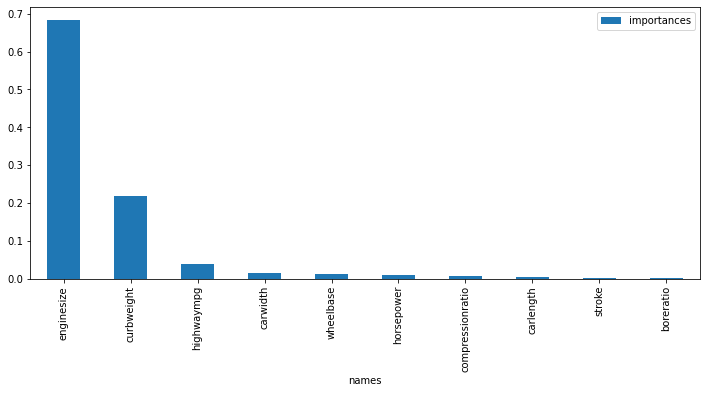

In [9]:
named_importance = pd.DataFrame(
    {
        'names': X.columns.tolist(),
        'importances': regr.feature_importances_
    }
)
named_importance.sort_values('importances', ascending=False, inplace=True)
named_importance.head(10)
named_importance[0:10].plot.bar(x='names', y='importances', figsize=(12,5));

#Ref: https://stats.stackexchange.com/questions/377033/collinearity-of-features-and-random-forest
#features like 'enginesize' and 'highwaympg' are significantly correlated to 'curbweight' & will likely inflate VIF in a linear regression model
#but in a random forest, since not all features are used during each split, this collinearity seems to not affect outcomes

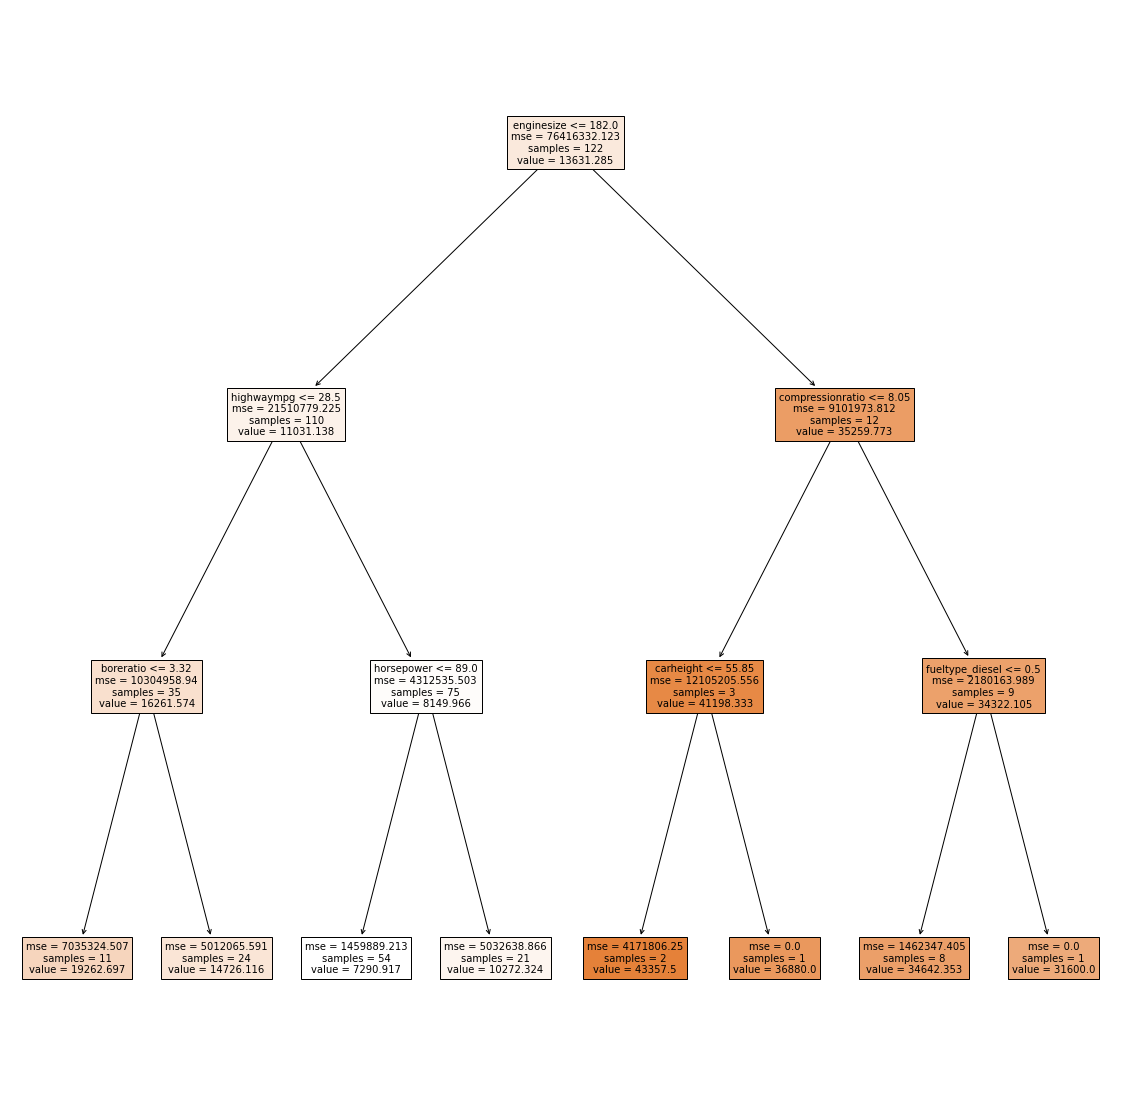

In [10]:
#each tree within a random forest model is different
#we can visualize a random tree to see the root node, the splits, features at each split, the leaves, the number of samples
#the predicted/ mean value of all samples in that leaf and the "mean squared error" to the actual values
plt.figure(figsize=(20,20))
_ = tree.plot_tree(regr.estimators_[0], feature_names=X.columns, filled=True)

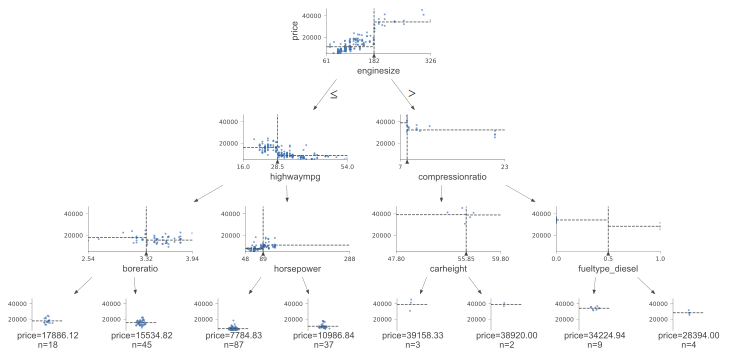

In [11]:
#this plot provides a different view of the splits - scatter plot of price v/s feature at the root/ split/ leaf and 
#the mean value (price) of all points in that region 
#for e.g. in the root node, the mean car price is about 10,000 ($?) for engine size < 182 (cu.in?)
#the actual mean values are in the plot above ($11,031.138)
viz = dtreeviz(regr.estimators_[0], X, y, feature_names=X.columns, target_name="price")
viz

## Explainable predictions

In [12]:
#linear models/ their preidctions are very easily explainable
#to get similar explanations from tree/ other models, we need to use additional algorithms, like LIME and SHAP
#LIME: https://www.kdnuggets.com/2016/08/introduction-local-interpretable-model-agnostic-explanations-lime.html
#SHAP: https://christophm.github.io/interpretable-ml-book/shap.html 

In [13]:
i = 25
carPrices.iloc[i].to_frame().T

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
25,1,Others,gas,std,four,sedan,fwd,front,93.7,157.3,...,90,bbl,2.97,3.23,9.4,68,5500,31,38,6692


In [14]:
#LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns, class_names=['price'], 
categorical_features=carPricesCatFeatures, verbose=True, mode='regression')

exp = explainer.explain_instance(X.iloc[i], regr.predict, num_features=5)

exp.show_in_notebook(show_table=True)
#see 'Predicted value' and compare with 'price'
#the explanation for the prediction shows where the splits ocurred and which features are pushing the 'price' up or down
#num_features allows selecting how many of the most important features to examine

Intercept 16585.270224533182
Prediction_local [8630.846966]
Right: 7306.702397216253


In [15]:
#SHAP
#again, predicted value of 'price' and the impact of features, along with their values for this specific row
explainer = shap.TreeExplainer(regr)
expected_value = explainer.expected_value
idx = X.shape[0] # all rows selected - small dataset in this case
select = range(idx)
features = X.iloc[select]
shap_values = explainer.shap_values(features)
feature_display = X.loc[features.index]

shap.initjs() # run to show the plot
shap.force_plot(explainer.expected_value, shap_values=shap_values[i,:], features=feature_display.iloc[i,:])

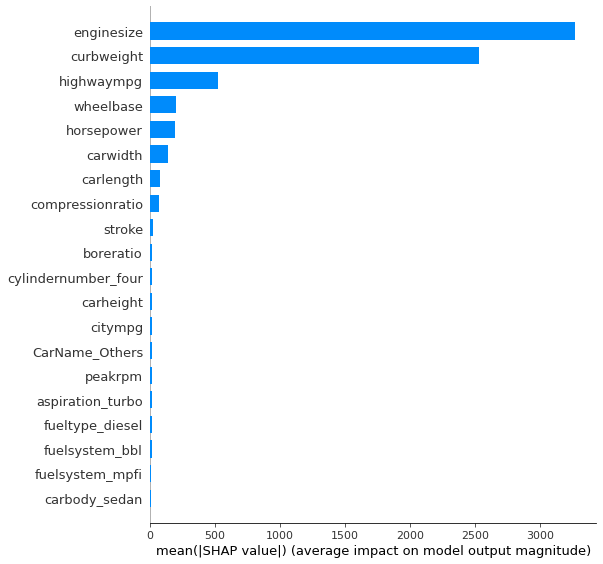

In [16]:
#feature importance for the model as a whole
shap.summary_plot(shap_values, feature_display, plot_type='bar')

# Other tree based models

In [17]:
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# create model
regr = RandomForestRegressor()
# evaluate model
scores = cross_val_score(regr, X, y, scoring='r2', cv=cv, n_jobs=-1)
#scoring='accuracy', 
# report performance
print('R Squared, mean & (std dev): %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

#Note: Random Forest model performance is usally measured using metrics like OOB score, MAE or MSE
#In this case, R Squared (ratio of the diffs between actual and predicted over actual and mean of actual)
#is used for apples to apples comparison to the linear model

R Squared, mean & (std dev): 0.921 (0.025)


In [18]:
#while it is possible to finetune random forest model fit hyperparameters, 
#it can be hard to beat the default settings sometimes, as in this case
regr = RandomForestRegressor(max_features= 'sqrt', n_estimators=50, max_depth=2)

param_grid = { 
    'n_estimators': [6, 12, 24, 36],
    'max_features': ['auto', 'log', 'sqrt'],
    'max_depth': [2,5,7]
}

CV_regr = GridSearchCV(estimator=regr, scoring='r2', param_grid=param_grid, cv= 5)
CV_regr.fit(X, y)
print('R Squared score of the best combination of hyperparameters provided: %.3f' % CV_regr.best_score_)
print('Best combination of hyperparameters provided:')
print(CV_regr.best_params_)

R Squared score of the best combination of hyperparameters provided: 0.666
Best combination of hyperparameters provided:
{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 24}


In [19]:
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# create model
model = AdaBoostRegressor(random_state=0, n_estimators=100)
# evaluate model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
#scoring='accuracy', 
# report performance
print('R Squared, mean & (std dev): %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

R Squared, mean & (std dev): 0.899 (0.033)


In [23]:
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# create model
model = AdaBoostRegressor(random_state=0, n_estimators=100)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#scoring='accuracy', 
# report performance
print('MSE, mean & (std dev): %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

MSE, mean & (std dev): -5845781.187 (1502177.061)


In [21]:
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# create model
model = GradientBoostingRegressor(random_state=0)
# evaluate model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
#scoring='accuracy', 
# report performance
print('R Squared, mean & (std dev): %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

R Squared, mean & (std dev): 0.926 (0.024)


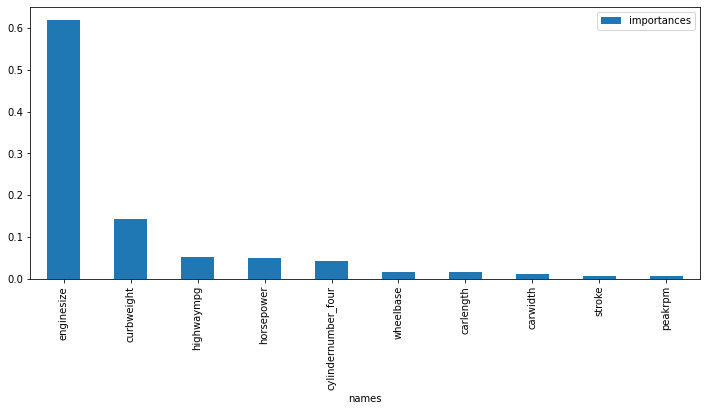

In [22]:
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X, y)

named_importance = pd.DataFrame(
    {
        'names': X.columns.tolist(),
        'importances': regr.feature_importances_
    }
)
named_importance.sort_values('importances', ascending=False, inplace=True)
named_importance.head(10)
named_importance[0:10].plot.bar(x='names', y='importances', figsize=(12,5));

# Conclusion:  
The EDA helped identify key features and potential data transformations to try. Regression plots and attempts to fit linear regression models showed the non-linear nature of the relationship. As a result, all statistically valid models showed poor fit & vice versa.  
  
In such a situation, a non-linear model (for example, any of the tree based approaches), can produce superior results, as measured on the same metric, R-squared/ explained variance.  
  
Even for tree based models, predictions can be explained using algorithms like LIME and SHAP